In [0]:
# Setting the year of Clinical trials
# Reading all three csv files required for analysis and cleaning the RDDs by omitting the header row and separating on delimiters.
processing_year = '2021'
trials_rdd = sc.textFile('/FileStore/tables/clinicaltrial_'+processing_year +'.csv')
rdd_without_header = trials_rdd.filter(lambda row: row.split('|')[0] != 'Id').distinct()
processed_trials_rdd = rdd_without_header.map(lambda row: row.split('|'))

mesh_rdd = sc.textFile('/FileStore/tables/mesh.csv')
mesh_without_header = mesh_rdd.filter(lambda row: row.split('|')[0] != 'term')
processed_mesh_rdd = mesh_without_header.map(lambda contents: contents.split(','))

pharma_rdd = sc.textFile('/FileStore/tables/pharma.csv')
pharma_without_header = pharma_rdd.filter(lambda row: row.replace("\"", "'").split("','")[0] != "'Company")
processed_pharma_rdd = pharma_without_header.map(lambda values: str(values).replace("\"", "'"))\
                                            .map(lambda pharmaRows: pharmaRows.split("','"))

In [0]:
#User defined function to fetch the column index by giving the column name
def fetchColumnIndex(columnName):
       if trials_rdd.first().split('|')[0] == 'Id':
            return trials_rdd.first().split('|').index(columnName)

#Function to evaluate values to get the frequency of each type of trial.
def type_map_reduce(rdd, field_num):
    return rdd.map(lambda column: (column[field_num],1))\
              .filter(lambda items: len(items[0]) != 0)\
              .reduceByKey(lambda v1,v2: v1+v2)\
              .sortBy(lambda rdd_values: -rdd_values[1])

#Function to evaluate columns with multiple rows and achieve a map of (item,1)
def conditions_map_reduce(rdd, fieldNum):
    return rdd.map(lambda column: column[fieldNum])\
              .flatMap(lambda conditions: conditions.split(','))\
              .filter(lambda items: len(items) != 0)\
              .map(lambda pairs: (pairs,1))

In [0]:
# 1. The number of studies in the dataset. You must ensure that you explicitly check distinct studies.
processed_trials_rdd.count()

Out[3]: 387261

In [0]:
#2. You should list all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type. 
#   These should be ordered from most frequent to least frequent.

type_frequency_rdd = type_map_reduce(processed_trials_rdd, fetchColumnIndex('Type'))
type_frequency_rdd.take(5)

Out[4]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

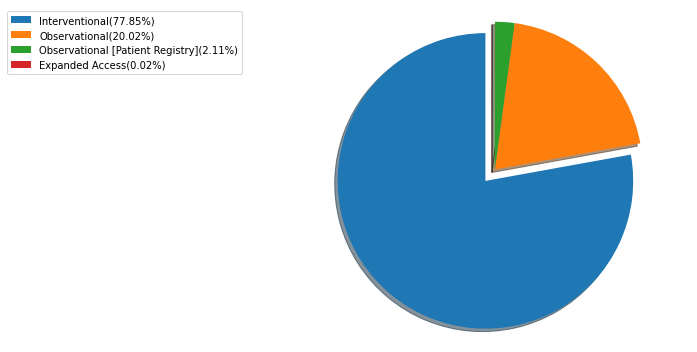

In [0]:
# Graphical representation of percentages of each type of study.
from matplotlib import pyplot as plt
import numpy as np
def getPercentage(type_count, total_count):
    return (type_count/total_count)*100

total_count = processed_trials_rdd.count()
percentage_rdd = type_frequency_rdd.map(lambda typeVal: (typeVal[0],np.round(getPercentage(typeVal[1],total_count), 2)))
percentage_rdd.take(5)

plt.figure(figsize=(10,5))
labels = percentage_rdd.map(lambda label: label[0]+'('+str(label[1])+'%)').collect()
percentages = percentage_rdd.map(lambda percent: percent[1]).collect()
explode = (0.1, 0, 0, 0)

fig, ax = plt.pie(percentages,explode=explode,shadow=True, startangle=90)
plt.legend(fig, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [0]:
# 3. The top 5 conditions (from Conditions) with their frequencies.

all_conditions_rdd = conditions_map_reduce(processed_trials_rdd, fetchColumnIndex('Conditions'))
conditions_rdd= all_conditions_rdd.reduceByKey(lambda v1,v2: v1+v2)\
                                  .sortBy(lambda rdd_values: -rdd_values[1])

conditions_rdd.take(5)

Out[6]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

In [0]:
# 4. Each condition can be mapped to one or more hierarchy codes. The client wishes to know the 
#5 most frequent roots (i.e. the sequence of letters and numbers before the first full stop) 
#after this is done.

condition_mesh_rdd = all_conditions_rdd.join(processed_mesh_rdd)

condition_code_rdd = condition_mesh_rdd.map(lambda codes: (codes[0], codes[1][1].split('.')[0]))\
                                       .map(lambda codeCount: (codeCount[1], 1))\
                                       .reduceByKey(lambda x1,x2: x1+x2)\
                                       .sortBy(lambda frequentCode: -frequentCode[1])
condition_code_rdd.take(10)

Out[7]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310),
 ('C06', 85646),
 ('C08', 70720),
 ('C13', 42599),
 ('C18', 41276),
 ('C12', 40161)]

In [0]:
#5. Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.
pharma_map_rdd = processed_pharma_rdd.map(lambda pharmaMap: (pharmaMap[1], 1))\
                                     .distinct()

sponsorsIndex = fetchColumnIndex('Sponsor')
trial_sponsors_rdd = processed_trials_rdd.map(lambda column: column[sponsorsIndex])\
                                         .map(lambda pairs: (pairs,1))\
                                         .reduceByKey(lambda v1,v2: v1+v2)\
                                         .sortBy(lambda sortedCompanies : -sortedCompanies[1])

sponsor_companies_rdd = trial_sponsors_rdd.leftOuterJoin(pharma_map_rdd)

sponsor_nonPharma_rdd = sponsor_companies_rdd.filter(lambda sponsors: sponsors[1][1] == None)\
                                             .map(lambda finalMap: (finalMap[0], finalMap[1][0]))\
                                             .sortBy(lambda sorted: -sorted[1])
sponsor_nonPharma_rdd.take(10)

Out[8]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

In [0]:
#6. Plot number of completed studies each month in a given year { for the submission dataset, the year
#   is 2021. You need to include your visualization as well as a table of all the values you have plotted
#   for each month.

from datetime import *
import calendar

#Creating a dictionary of months using Python's calendar library. This generates an output as follows:
#{'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
#The month name is being used as the key to access the value of the month(number) and further sorted on the month_num

calendar_enum = enumerate(calendar.month_abbr[1:], start=1)
dictionary_months = dict((month, month_num) for month_num, month in calendar_enum)

completionIndex = fetchColumnIndex('Completion') 
statusIndex = fetchColumnIndex('Status') 
completion_frequency_rdd = processed_trials_rdd.filter(lambda spaces: len(spaces[completionIndex])!=0)\
                                               .map(lambda column: (datetime.strptime(column[completionIndex], '%b %Y'),column[statusIndex]))\
                                               .filter(lambda element : (element[0].year == int(processing_year)) & (element[1] == 'Completed'))\
                                               .map(lambda month: (datetime.strftime(month[0],'%b'),1))\
                                               .reduceByKey(lambda v1,v2: v1+v2)\
                                               .sortBy(lambda sorted: dictionary_months.get(sorted[0]))
completion_frequency_rdd.take(12)


Out[9]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

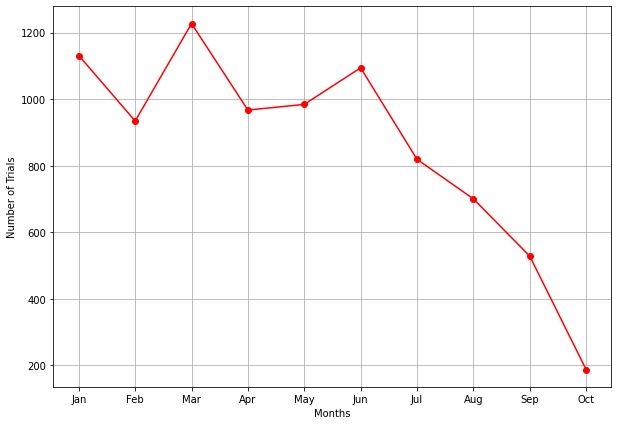

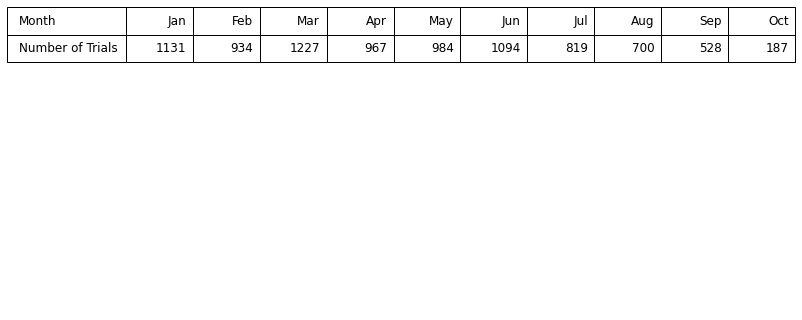

In [0]:
#Visualising results of #6
from matplotlib import pyplot as plt
x_axis = completion_frequency_rdd.map(lambda x_axis: x_axis[0]).collect()
y_axis = completion_frequency_rdd.map(lambda y_axis: y_axis[1]).collect()

data = [x_axis,y_axis]
row_headers = ["Month", "Number of Trials"]

fig = plt.figure(figsize=(10,7))
plt.plot(x_axis,y_axis,color='red', marker='o')
plt.xlabel("Months")
plt.ylabel("Number of Trials")
plt.savefig("Number of Clinical trials per month")
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
ax_table= ax.table(cellText=data,
                   colLabels=None,
                   colColours=None,
                   rowColours=None,
                   rowLabels=row_headers,
                   colWidths=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],
                   loc="top")

ax_table.scale(1, 2)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(12)

plt.subplots_adjust(bottom=0.01)
plt.show()

In [0]:
# Further analysis 1 - Comparison between trials having and not having interventions for each trial type

typeIndex = fetchColumnIndex('Type') 
interventionIndex = fetchColumnIndex('Interventions') 
intervention_rdd = processed_trials_rdd.map(lambda inttype: (inttype[typeIndex],inttype[interventionIndex]))\
                                       .filter(lambda nonint: nonint[1] != '')\
                                       .map(lambda withInt : (withInt[0], 1))\
                                       .reduceByKey(lambda v1,v2: v1+v2)\
                                       .sortByKey()

no_intervention_rdd = processed_trials_rdd.map(lambda inttype: (inttype[typeIndex],inttype[interventionIndex]))\
                                          .filter(lambda nonint: nonint[1] == '')\
                                          .map(lambda withoutInt : (withoutInt[0], 1))\
                                          .reduceByKey(lambda v1,v2: v1+v2)\
                                          .sortByKey()

total_interventions = intervention_rdd.join(no_intervention_rdd)

intervention_types = total_interventions.map(lambda x_axis: x_axis[0]).collect()
has_intervention = total_interventions.map(lambda y_axis: y_axis[1][0]).collect()
no_intervention = total_interventions.map(lambda y_axis: y_axis[1][1]).collect()

total_interventions.take(5)

Out[11]: [('Observational', (6502, 71038)),
 ('Observational [Patient Registry]', (593, 7587)),
 ('Expanded Access', (37, 32)),
 ('Interventional', (126292, 175180))]

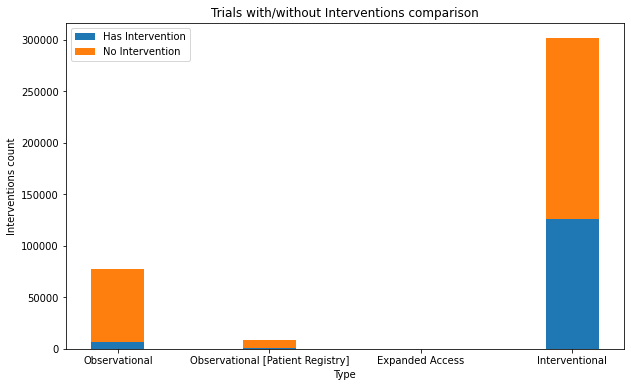

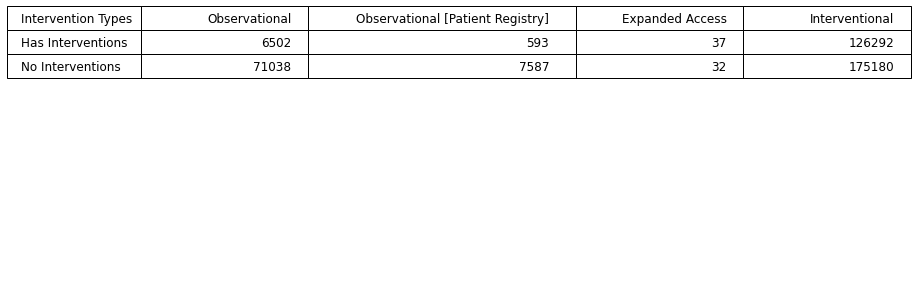

In [0]:
# Plotting a graph for Further Analysis 1
import matplotlib.pyplot as plt

width = 0.35 

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(intervention_types, has_intervention,width, label='Has Intervention')
ax.bar(intervention_types, no_intervention, width, bottom=has_intervention, label = 'No Intervention')

ax.set_ylabel('Interventions count')
ax.set_xlabel('Type')
ax.set_title('Trials with/without Interventions comparison')
ax.legend()

fig, ax = plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
ax_table= ax.table(cellText=[intervention_types,has_intervention,no_intervention],
                   colLabels=None,
                   colColours=None,
                   rowColours=None,
                   rowLabels=['Intervention Types','Has Interventions','No Interventions'],
                   colWidths=[0.5,0.8,0.5,0.5],
                   loc="top")

ax_table.scale(1, 2)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(12)

plt.show()

In [0]:
#Further Analysis 2: Top 10 Pharmaceutical companies sponsoring the clinical trials

pharma_sponsor_companies_rdd = trial_sponsors_rdd.join(pharma_map_rdd)

sponsor_pharma_rdd = pharma_sponsor_companies_rdd.map(lambda finalM: (finalM[0], finalM[1][0]))\
                                                 .sortBy(lambda sorted: -sorted[1])

sponsor_pharma_rdd.take(10)



Out[13]: [('GlaxoSmithKline', 3378),
 ('AstraZeneca', 2691),
 ('Pfizer', 2645),
 ('Boehringer Ingelheim', 1967),
 ('Sanofi', 1274),
 ('Bristol-Myers Squibb', 1171),
 ('Amgen', 744),
 ('Novartis', 690),
 ('Gilead Sciences', 563),
 ('AbbVie', 525)]

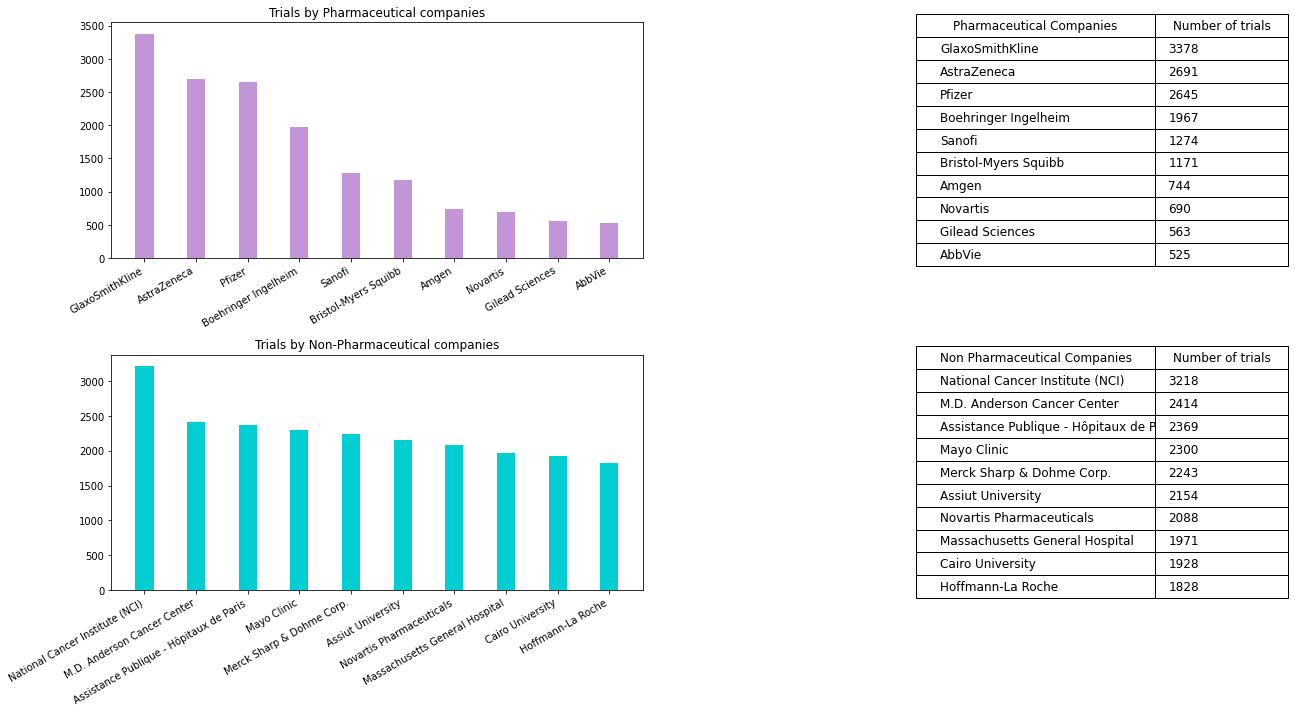

In [0]:
#Plotting graphs using matplotlib for Further Analysis 2
import matplotlib.pyplot as plt

pharma_result = sponsor_pharma_rdd.take(10)
pharma_companies = sponsor_pharma_rdd.map(lambda x_axis: x_axis[0]).take(10)
pharma_trials_count = sponsor_pharma_rdd.map(lambda y_axis: y_axis[1]).take(10)

non_pharma_result = sponsor_nonPharma_rdd.take(10)
non_pharma_companies = sponsor_nonPharma_rdd.map(lambda x_axisn: x_axisn[0]).take(10)
non_pharma_trials_count = sponsor_nonPharma_rdd.map(lambda y_axisn: y_axisn[1]).take(10)

width = 0.35
fig,ax = plt.subplots(2,2,figsize=(25,10),gridspec_kw={'width_ratios':[2,1], 'height_ratios':[1,1]})

ax[0,0].bar(pharma_companies, pharma_trials_count, width, color = '#c295d7')
plt.setp(ax[0,0].get_xticklabels(), rotation=30, horizontalalignment='right')
ax[0,0].set_title('Trials by Pharmaceutical companies')
ax[0,1].axis('tight')
ax[0,1].axis('off')
ax_table_1= ax[0,1].table(cellText=pharma_result,
                          colLabels=['Pharmaceutical Companies', 'Number of trials'],
                          colColours=None,
                          colWidths=[0.9,0.5],
                          cellLoc = 'left',
                          loc="right")

ax_table_1.scale(1, 2)
ax_table_1.auto_set_font_size(False)
ax_table_1.set_fontsize(12)

ax[1,0].bar(non_pharma_companies, non_pharma_trials_count,width, color = '#00ced1')
plt.setp(ax[1,0].get_xticklabels(), rotation=30, horizontalalignment='right')
ax[1,0].set_title('Trials by Non-Pharmaceutical companies')

ax[1,1].axis('tight')
ax[1,1].axis('off')
ax_table_2= ax[1,1].table(cellText=non_pharma_result,
                          colLabels=['Non Pharmaceutical Companies', 'Number of trials'],
                          colColours=None,
                          colWidths=[0.9,0.5],
                          cellLoc = 'left',
                          loc="right")

ax_table_2.scale(1, 2)
ax_table_2.auto_set_font_size(False)
ax_table_2.set_fontsize(12)

plt.tight_layout()
plt.subplots_adjust(right=0.5)
plt.show()

In [0]:
# Further analysis 3: Top 10 descriptors for interventions defined in trials.
all_interventions_rdd = conditions_map_reduce(processed_trials_rdd, fetchColumnIndex('Interventions'))

intervention_mesh_rdd = all_interventions_rdd.join(processed_mesh_rdd)

intervention_code_rdd = intervention_mesh_rdd.map(lambda codes: (codes[0], codes[1][1].split('.')[0]))\
                                             .map(lambda codeCount: (codeCount[1], 1))\
                                             .reduceByKey(lambda x1,x2: x1+x2)\
                                             .sortBy(lambda frequentCode: -frequentCode[1])
intervention_code_rdd.take(10)

Out[15]: [('D02', 139216),
 ('D03', 101782),
 ('D12', 87363),
 ('D04', 39005),
 ('D27', 17965),
 ('D01', 16972),
 ('D13', 13713),
 ('D06', 11729),
 ('D23', 10637),
 ('D09', 9801)]